\setcounter{secnumdepth}{0}

# Assignment 4 - Stochastic and controlled systems

    Name: Clara Periago Serrano
    Student #: s1067476

In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr

# General RK4 function
def get_rk4(f, dt):
    def rk4_scan_fn(carry, t):
        y, args = carry
        dt2 = dt / 2.0
        k1 = f(t, y, args)
        k2 = f(t + dt2, y + dt2*k1, args)
        k3 = f(t + dt2, y + dt2*k2, args)
        k4 = f(t + dt, y + dt*k3, args)
        y_next = y + (dt/6.) * (k1 + 2*k2 + 2*k3 + k4)
        carry = y_next, args
        return carry, y_next
        
    return rk4_scan_fn

# Exercise 1: Compound Poisson process

Simulate the compound Poisson process under different intensities. Compare at least two jump size distributions (see slide 52 of 'stochastic processes') and describe the processes you find.

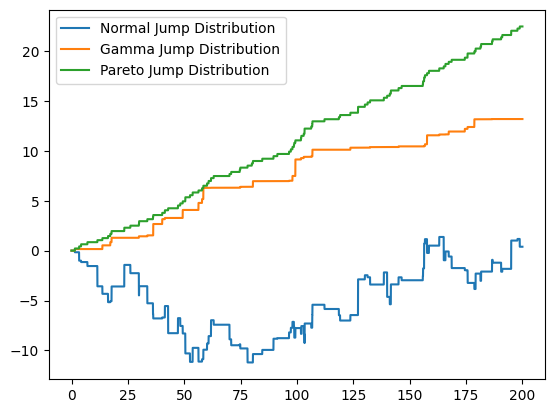

In [119]:
intensities = [0.4, 0.8]

key = jr.key(42)

dt = 0.01
xs = jnp.arange(0, 200, dt)

def compound_poisson(intensity = 0.5, dist_fn = None, dt = 0.01, max_N=10):
    """
    dist_fn must be a callable taking a key, and a shape for how many samples
    max_N must be an integer stating the maximum amount of jumps allowed per step
    """
    if dist_fn is None:
        dist_fn = lambda k, s: jr.normal(k, shape=s)

    @jax.jit
    def poisson_process(c, t):
        y, key = c

        nkey, jumpkey, nextkey = jr.split(key, 3)
        # first sample how many jumps we will take (delta N)
        N = jr.poisson(nkey, intensity * dt, shape=())

        # N = max((N).size, 1) # this is one approach to fixing the jit error but it doesn't allow N being zero
        # print(N)
        # jax.debug.print("{N}", N=N)

        # okay so here because of jax jit stuff we can't pass N directly as a shape, since it's a dynamic value
        # but shape must be static, so we always pass a fixed amount of jumps
        samples = dist_fn(jumpkey, (max_N,))
        # then we mask out only the amount we sampled from the poisson
        mask = jnp.arange(max_N) < N

        # so we basically discard (multiply by zero) entries that don't make the N cutoff
        delta_y = jnp.sum(samples * mask)
        y1 = y + delta_y

        return (y1, nextkey), y1

    return poisson_process


_, ys_normal = jax.lax.scan(
    compound_poisson(intensity=0.5, dist_fn=lambda k, s: 1. * jr.normal(k, shape=s), dt=dt), (0, key), xs
)

_, ys_gamma = jax.lax.scan(
    compound_poisson(intensity=0.5, dist_fn=lambda k, s: 1. * jr.gamma(k, a=.1, shape=s), dt=dt), (0, key), xs
)

_, ys_pareto = jax.lax.scan(
    compound_poisson(intensity=0.5, dist_fn=lambda k, s: .2 * jr.pareto(k, b=8., shape=s), dt=dt), (0, key), xs
)

plt.plot(xs, ys_normal, label="Normal Jump Distribution")
plt.plot(xs, ys_gamma, label="Gamma Jump Distribution")
plt.plot(xs, ys_pareto, label="Pareto Jump Distribution")
plt.legend();


In the plot we can see some examples of the same (compound) Poisson process using different jump distributions. I tried some of the distributions listed on the slides, namely the Normal, Gamma and Pareto distributions, all parametrized and scaled such that they fit in the same plot.

Both Pareto and Gamma represent non-negative jumps only, as opposed to the Normal function.

# Exercise 2: Jump-diffusion process

Simulate a **stochastic** harmonic oscillator with **jumps**. Generate an ensemble of trajectories. Plot a couple of trajectories of this ensemble and plot the confidence interval of the whole ensemble. Explain what happens with the confidence interval when you change the number of samples in your ensemble.

Text(0.5, 0.98, 'Jump harmonic oscillator')

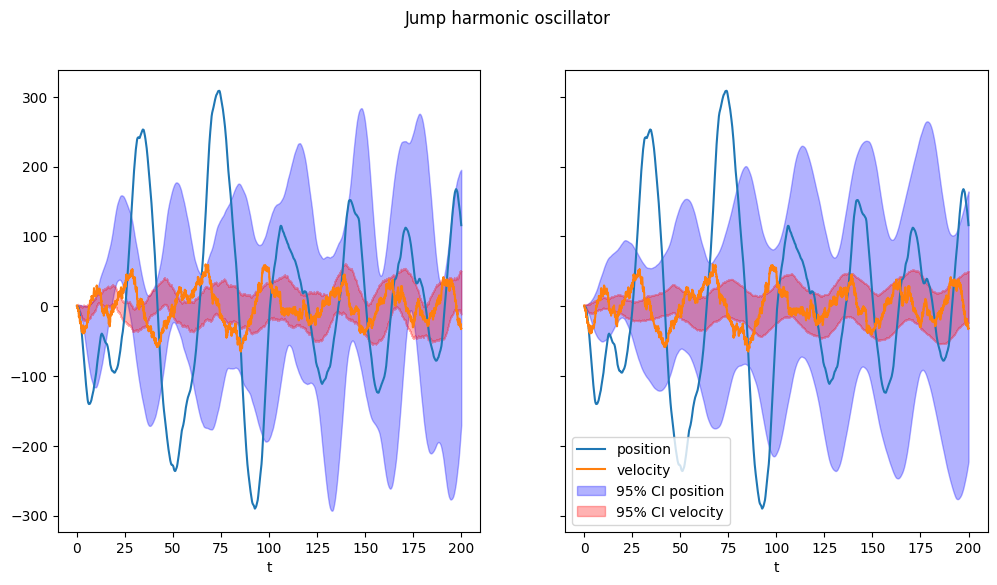

In [ ]:
def stochastic_harmos_jumps(cpps = None, omega = 1., gamma = 0.1, mu = 0., sigma = 0.1, nu = 1., cpp_intensity = 0.1, dt = 0.01):
    """
    cpps must be a collection of compound poisson processes (as defined in the previous exercise)
    """
    if cpps is None:
        cpps = ([compound_poisson(cpp_intensity, dt=dt)]) # by default a single poisson

    @jax.jit
    def shoj(c, t):
        (x, v), key = c

        wkey, cppkey, nextkey = jr.split(key, 3)

        # normal oscillator dynamics
        dx = v
        dv = -omega**2 * x - gamma * v

        # jump dynamics
        # first delta W
        delta_w = jnp.sqrt(dt) * sigma * jr.normal(wkey)
        # here compute all _k_ poisson processes
        delta_y = jnp.array([cpp((0., kk), 0.)[1] for cpp, kk in zip(cpps, jr.split(cppkey, len(cpps)))])
        # dy is zero most of the time, that means our process has too small of a intensity
        # jax.debug.print("{dy} {dw}", dy=delta_y, dw=delta_w)

        # update dv with the jump info
        dv += mu * dt + delta_w + jnp.sum(delta_y * nu) # nu is most likely always a scalar

        x1 = x + dx * dt
        v1 = v + dv * dt

        return (jnp.array([x1, v1]), nextkey), jnp.array([x1, v1])

    return shoj


# for some reason the parameters indicated in the lecture barely produce any results
# i have to use really high values of nu (like 20), when  in the lecture they use 1.
# that controls the jump "amplitude", and likewise i also have to increase the jump rate (cpp_intensity, \lambda),
#  which in the lecture is 0.1 but i need 100 times that.....
step_fn = stochastic_harmos_jumps(
    omega=0.2,
    gamma=0.,
    sigma=5.,
    nu=200.,
    cpp_intensity=20.,
    dt=dt
)

M = 20 # 20 repeats

xs = jnp.arange(0, 200, dt)

def run_trajectory(key):
    _, ys = jax.lax.scan(step_fn, (jnp.array([0., 1.]), key), xs)
    return ys 


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

def plot_all(trajectories, ax):
    x_all = trajectories[:, :, 0]  # (M, len(xs))
    v_all = trajectories[:, :, 1]


    # https://en.wikipedia.org/wiki/Confidence_interval#Methods_of_derivation
    # if i understand correctly this should do it
    # from the wiki page, our c value has to be the required threshold 
    #  in the student t distrubution to get 95% (approx 1.96)
    # i think it looks sensible but i'm not sure if the equation is right
    x_mean = jnp.mean(x_all, axis=0)
    x_std = jnp.std(x_all, axis=0)
    x_upper = x_mean + 1.96 * x_std / jnp.sqrt(M)
    x_lower = x_mean - 1.96 * x_std / jnp.sqrt(M)

    # same for v
    v_mean = jnp.mean(v_all, axis=0)
    v_std = jnp.std(v_all, axis=0)
    v_upper = v_mean + 1.96 * v_std / jnp.sqrt(M)
    v_lower = v_mean - 1.96 * v_std / jnp.sqrt(M)

    # plot one full trajectory
    ax.plot(xs, x_all[0], label="position")
    ax.plot(xs, v_all[0], label="velocity")

    # rest of the trajectories simply as 95% CI
    ax.fill_between(xs, x_lower, x_upper, color="blue", alpha=0.3, label="95% CI position")
    ax.fill_between(xs, v_lower, v_upper, color="red", alpha=0.3, label="95% CI velocity")
    ax.set_xlabel("t")

M1, M2 = (20, 100) # ensemble of 20 and 50 runs

# we share the same key so that the first M1 runs are the same so we can compare the plots better
all_trajectoriesM1 = jax.vmap(run_trajectory)(jr.split(key, M1))
all_trajectoriesM2 = jax.vmap(run_trajectory)(jr.split(key, M2))

plot_all(all_trajectoriesM1, ax1)
plot_all(all_trajectoriesM2, ax2)

plt.legend();
fig.suptitle("Jump harmonic oscillator")


As we increase the number of sample runs in the ensemble, the effects of the random jumps are averaged out, leading to a (almost) regular, sinusoidal shape for the confidence intervals of $x$ and $v$.

# Exercise 3: Numerical simulation of the forced damped pendulum

## Exercise 3.1

Simulate the forced damped pendulum and show its position over time with $u(t) = a \cos(kt)$ with $a=1.5$ and $k=2/3$, and use $x_0 = [-\pi, 1.5 \pi]$.

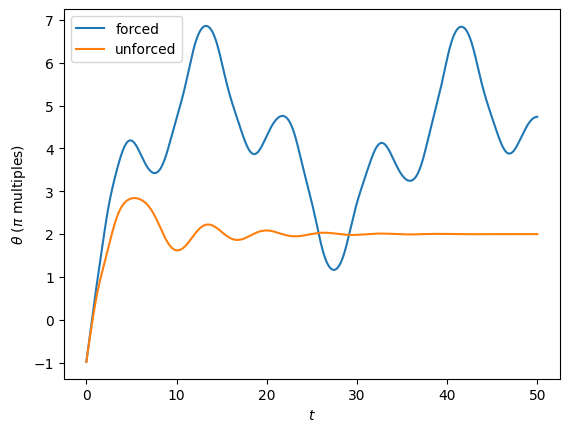

In [233]:
def forced_pendulum(t, y, args): # function to pass to the solver
    omega2, gamma, a, k = args
    theta, ang_v = y

    u_t = a * jnp.cos(k * t)

    return jnp.array([
        # change in theta is just omega (angular velocity)
        ang_v,

        # rate of change in velocity depends on the equation 
        # for the damped pendulum + the control param u(t)
        -omega2 * jnp.sin(theta) - gamma * ang_v + u_t
    ])

pendulum = get_rk4(forced_pendulum, dt=dt)

xs = jnp.arange(0, 50, dt)
OMEGA2 = 1. # starting velocity
GAMMA = 0.3 # damping factor
X0 = jnp.array([-jnp.pi, 1.5 * jnp.pi])

_, ys_unforced = jax.lax.scan(
    pendulum,
    (
        X0,
        (OMEGA2, GAMMA, 0, 2./3)  # omega2, gamma, a, k
    ),
    xs
)
_, ys = jax.lax.scan(
    pendulum,
    (
        X0,
        (OMEGA2, GAMMA, 1.5, 2./3)  # omega2, gamma, a, k
    ),
    xs
)

def unrwap_theta(theta):
    return jnp.arctan2(jnp.sin(theta), jnp.cos(theta))

plt.plot(xs, (ys[:, 0] / jnp.pi), label="forced")
plt.plot(xs, (ys_unforced[:, 0] / jnp.pi), label="unforced")
plt.xlabel("$t$")
plt.ylabel(r"$\theta$ ($\pi$ multiples)")
plt.legend();

We can see the unforced oscillator quickly settle onto a stable point (seems to be $2\pi$), while the forced oscillator keeps turning due to the control factor $u(t)$.

## Exercise 3.2
Now simulate the forced damped pendulum with different control inputs (vary the driving frequency $k$). 

How does the time dependency of u(t) change the dynamics of the system? And how is this time dependency reflected in the phase plane?

0.5 -0.9849984 6.012177 18.887812
0.6666666666666666 -0.9849984 6.860453 21.55275
1.0 -0.9849984 6.860453 15.6315775
-0.9849984 6.860453


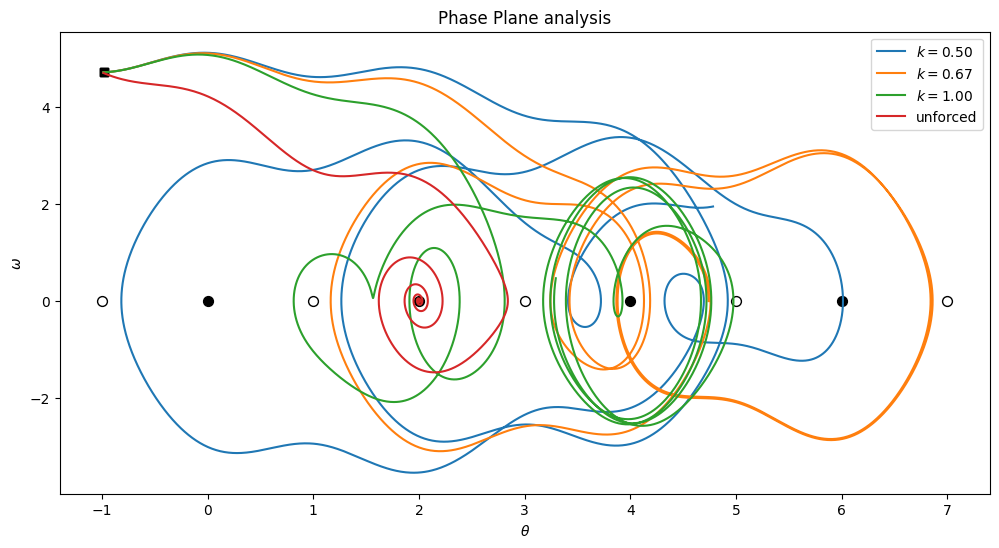

In [234]:
ks = [.5, 2./3, 1.]

fig, ax = plt.subplots(figsize=(12, 6))

theta_min, theta_max = jnp.inf, -jnp.inf

for k in ks:
    _, ys = jax.lax.scan(
        pendulum,
        (
            X0,
            (OMEGA2, GAMMA, 1.5, k)  # gamma, a, k
        ),
        xs
    )

    theta = ys[:, 0]   # angle
    omega = ys[:, 1]   # angular velocity

    # we express theta as pi multiples since it's more clear in the plot what's going on
    theta_wrapped = theta / jnp.pi

    # this is a bit janky but we don't know if one theta will span more/less than others
    theta_min, theta_max = min(theta_min, theta_wrapped.min()), max(theta_max, theta_wrapped.max())
    print(k, theta_min, theta_max, theta.max())

    ax.plot(theta_wrapped, omega, label=rf"${k=:.2f}$")
    ax.scatter(theta_wrapped[0], omega[0], marker="s", color="black") # for the starting position, should be the same for all runs

ax.plot(ys_unforced[:, 0] / jnp.pi, ys_unforced[:, 1], label=rf"unforced")

ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\omega$")
ax.set_title("Phase Plane analysis")

print(theta_min, theta_max)

# based on the absolute min/max of all thetas plotted before, we can plot stable points at pi multiples
n_min = jnp.floor(theta_min)
n_max = jnp.ceil(theta_max)
fixed_points = jnp.arange(n_min, n_max + 1) # in terms of multiples of pi
for p in (fixed_points):
    # if we are in a multiple of pi that is even the point is stable
    if p % 2 == 0:  # stable
        ax.scatter(p, 0, color="black", s=50)
    else:  # unstable/saddle
        ax.scatter(p, 0, facecolors='white', edgecolors='black', s=50, lw=1)

# i tried to replicate the figure from the lectures as much as possible but 
#   i don't know how to do the fancy arrow field plot...

plt.legend()
plt.show()


We plot four different oscillators in the figure above. For the baseline (`unforced`) the control element $u(t)$ is always zero. This results in a typical (damped) harmonic oscillator, eventually settling on a stable point at $\theta=2\pi$.

For the other trajectories, the only difference is in the value of $k$. We can see that lower values result in more soft curves and slow turns (corresponding to a lower frequency for the control signal), while higher frequency values push the pendulum strongly in different directions. This is because the control signal depends on time (`xs` in the code), so higher frequencies will result in a bigger change in a smaller amount of steps.



# Exercise 4: Stability analysis

The uncontrolled Lotka-Volterra model has a fixed point at $(\gamma/\delta, \alpha/\beta)$. Linearize the system at the fixed point and perform a stability analysis to characterize the behaviour of the system near the fixed point. You can make use of the following function to determine the eignevalues: `numpy.linalg.eig(A)`

I had to google what the Lotka-Volterra system is, but apparently it is [defined as](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations):

$$

\begin{align*}

    \dot{x} &= \alpha x - \beta x y, \\
    \dot{y} &= - \gamma y + \delta x y, \\

\end{align*}

$$

To observe the stability of the system around the given fixed point, we must linearize the system. First, we compute the Jacobian:

$$

\begin{align*}

    J(x, y) &=

\begin{bmatrix}
\frac{\partial \dot{x}}{\partial x} & \frac{\partial \dot{x}}{\partial y} \\
\frac{\partial \dot{y}}{\partial x} & \frac{\partial \dot{y}}{\partial y}
\end{bmatrix}

&=

\begin{bmatrix}
\alpha - \beta y & - \beta x \\
\delta y & -\gamma + \delta x
\end{bmatrix}
\\

\end{align*}

$$

We then evaluate the jacobian at the given fixed point:

$$

\begin{align*}

J(x^*, y^*) &= J(\gamma/\delta, \alpha/\beta) &=
    \begin{bmatrix}
        \alpha - \beta \frac{\alpha}{\beta} & - \beta \frac{\gamma}{\delta} \\
        \delta \frac{\alpha}{\beta} & - \gamma + \delta \frac{\gamma}{\delta}
    \end{bmatrix}

&= \begin{bmatrix}
        0 & - \beta \frac{\gamma}{\delta} \\
        \delta \frac{\alpha}{\beta} & 0
    \end{bmatrix}


\end{align*}

$$

Our linearized system is given by:


$$

\begin{align*}

\begin{bmatrix}
    \dot{\hat{x}} \\
    \dot{\hat{y}}
\end{bmatrix}

&=

J(x^*, y^*) 
\begin{bmatrix}
    \hat{x} \\
    \hat{y}
\end{bmatrix}, \\

\text{where } \hat{x} &= x - x^*, \hat{y} = y - y^*



\end{align*}

$$

In [248]:
def lotka_volterra(t, z, args):
    alpha, beta, gamma, delta = args
    x, y = z
    dx = alpha * x - beta * x * y
    dy = delta * x * y - gamma * y
    return jnp.array([dx, dy])

def lv_jacobian(x, y, args):
    alpha, beta, gamma, delta = args
    return jnp.array(
        [[alpha - beta * y, -beta * x],
        [delta * y, delta * x - gamma]]
    )

lv = get_rk4(lotka_volterra, dt=dt)

xs = jnp.arange(0, 100, dt)
# i have no idea what good values for the parameters are....
ALPHA = 0.5
BETA = 0.5
GAMMA = 0.5
DELTA = 0.5
all_args = (ALPHA, BETA, GAMMA, DELTA)

# fixed point
x_star = GAMMA / DELTA
y_star = ALPHA / BETA

# we can start around the fixed point
X0 = jnp.array([x_star * 1.1, y_star * .9])


# evaluating the jacobian at the fixed point, then getting the eigenvalues
J_star = lv_jacobian(x_star, y_star, all_args)
eigvals, eigvecs = jnp.linalg.eig(J_star)

print(f"J_star =\n {J_star}")
print(f"{eigvals=}")

# this is not really needed for the exercise
_, ys_lv = jax.lax.scan(
    lv,
    (
        X0,
        all_args
    ),
    xs
)


# plt.plot(ys_lv)
# plt.scatter(x_star, y_star, label="fixed point")




J_star =
 [[ 0.  -0.5]
 [ 0.5  0. ]]
eigvals=Array([0.+0.49999997j, 0.-0.49999997j], dtype=complex64)


Given the eigenvalues are both purely imaginary, we can conclude the system is neutrally stable around the given fixed point. We computed the eigenvalues for a hardcoded set of values for $\alpha$, $\beta$, $\gamma$ and $\delta$, but we can also show that this applies for any value, analytically, by computing the eigenvalues by hand instead of with numpy.

$$

\begin{align*}

\det(J(x^*, y^*) - \lambda I)  &=

\begin{bmatrix}
    -\lambda & - \beta \frac{\gamma}{\delta} \\
    \delta \frac{\alpha}{\beta} & -\lambda
\end{bmatrix} \\

&= \lambda^2 - \left( - \beta \frac{\gamma}{\delta} \delta \frac{\alpha}{\beta} \right) \\
&= \lambda^2 + \alpha \gamma = 0 \rightarrow \\
\lambda &= \sqrt{-\alpha\gamma} = \pm i \sqrt{\alpha\gamma}

\end{align*}

$$

And since our eigenvalues will always have (only) $i$ (that is, be purely imaginary), we can conclude that the system is always neutrally stable.